In [1]:
%pip install pandas pyarrow Pillow torchvision matplotlib scikit-learn torch datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import pyarrow as pa
import io
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
import numpy as np

In [3]:
# verification de cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [4]:
df_inspection = pd.read_parquet('data/train/0000.parquet')
print("colonnes = ", df_inspection.columns.tolist())

print("\nExemple de la première ligne :")
print(df_inspection.iloc[0])

colonnes =  ['image_file_path', 'image', 'labels']

Exemple de la première ligne :
image_file_path    /storage/hf-datasets-cache/all/datasets/603406...
image              {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
labels                                                             0
Name: 0, dtype: object


In [5]:
# Charger le dataset

class ChestXrayDataset(Dataset):

    # Initialiser le dataset en chargeant les données depuis un fichier Parquet
    def __init__(self, parquet_file_path, transform=None):
        self.data = pd.read_parquet(parquet_file_path)
        self.transform = transform
    
    # Retourner la taille du dataset
    def __len__(self):
        return len(self.data)
    
    # Obtenir un échantillon du dataset à l'index donné
    def __getitem__(self, idx):
        # Récupérer la ligne correspondante à l'index
        row = self.data.iloc[idx]
        # Extraire les bytes de l'image et le label
        image_bytes = row['image']['bytes']
        label = row['labels']
        
        # Convertir les bytes en image PIL
        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        
        # Appliquer les transformations si elles sont définies
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Redimensionne
    transforms.ToTensor(),         # Convertit en tenseur
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalise les valeurs des pixels
])

# Créer les datasets pour l'entraînement, la validation et le test
train_ds = ChestXrayDataset('data/train/0000.parquet', transform=transform)
val_ds   = ChestXrayDataset('data/val/0000.parquet',   transform=transform)
test_ds  = ChestXrayDataset('data/test/0000.parquet',  transform=transform)

# Créer les DataLoaders pour l'entraînement, la validation et le test
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Afficher la taille des datasets
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")


Train dataset size: 1165
Validation dataset size: 4077
Test dataset size: 582


In [7]:
def check_ration(dataset, name):
    labels = [label for _, label in dataset]
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Distribution des classes dans le dataset {name}:") 
    for u, c in zip(unique, counts): print(f"Classe {u}: {c} échantillons ({c/len(dataset)*100:.2f}%)") 

check_ration(train_ds, "train") 
check_ration(val_ds, "validation") 
check_ration(test_ds, "test")


Distribution des classes dans le dataset train:
Classe 0: 304 échantillons (26.09%)
Classe 1: 861 échantillons (73.91%)
Distribution des classes dans le dataset validation:
Classe 0: 1104 échantillons (27.08%)
Classe 1: 2973 échantillons (72.92%)
Distribution des classes dans le dataset test:
Classe 0: 171 échantillons (29.38%)
Classe 1: 411 échantillons (70.62%)


In [8]:
image_batch, label_batch = next(iter(train_loader))
print(f"Forme de l'image reçue : {image_batch.shape}")

Forme de l'image reçue : torch.Size([32, 3, 224, 224])


In [9]:
# modele simple pour tester
class PneumoniaClassifier(nn.Module):
    def __init__(self):
        super(PneumoniaClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # 3 canaux d'entrée (RGB), 16 filtres de sortie
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # 16 canaux d'entrée, 32 filtres de sortie
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 32 canaux d'entrée, 64 filtres de sortie
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # Réduit la taille de moitié
        
        self.fc1 = nn.Linear(64 * 28 * 28, 224) # Couche fully connected pour la classification binaire (pneumonie ou pas)
        self.fc2 = nn.Linear(224, 64) # Couche fully connected intermédiaire
        self.fc3 = nn.Linear(64, 1) # Couche de sortie pour la classification binaire
        
        self.dropout = nn.Dropout(0.5)  # Ajout du dropout avec probabilité 0.5

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # Convolution + ReLU + Pooling
        x = self.pool(torch.relu(self.conv2(x))) # Convolution + ReLU + Pooling
        x = self.pool(torch.relu(self.conv3(x))) # Convolution + ReLU + Pooling
        
        x = x.view(-1, 64 * 28 * 28) # Aplatir les caractéristiques pour la couche fully connected
        x = torch.relu(self.fc1(x)) # Couche fully connected + ReLU
        x = self.dropout(x)  # Appliquer dropout après fc1
        x = torch.relu(self.fc2(x)) # Couche fully connected intermédiaire + ReLU
        x = self.dropout(x)  # Appliquer dropout après fc2
        x = torch.sigmoid(self.fc3(x)) # Couche de sortie avec activation sigmoïde pour la classification binaire
        
        return x

In [10]:
model = PneumoniaClassifier().to(device)
print(model)

criterion = nn.BCELoss() # Binary Cross Entropy Loss pour la classification binaire
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Optimiseur Adam avec un taux d'apprentissage de 0.001

PneumoniaClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=224, bias=True)
  (fc2): Linear(in_features=224, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [11]:
# boucle d'entraînement
num_epochs = 5
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1) # Assurez-vous que les labels sont de la meme forme que les images
        
        optimizer.zero_grad() # Réinitialiser les gradients
        
        outputs = model(images) # Passer les images à travers le modèle
        loss = criterion(outputs, labels) # Calculer la perte
        loss.backward() # Propagation arrière pour calculer les gradients
        optimizer.step() # Mettre à jour les poids du modèle
        
        train_loss += loss.item() * images.size(0) # Accumuler la perte totale
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): # on n'a pas besoin de calculer les gradients pour la validation, on observe juste les performances du modèle
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth') # Sauvegarder le modèle avec la meilleure performance sur la validation
    
    # Afficher les pertes moyennes pour l'entraînement et la validation
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_ds):.4f}, Val Loss: {val_loss/len(val_ds):.4f}")

Epoch 1/5, Train Loss: 0.4938, Val Loss: 0.2457
Epoch 2/5, Train Loss: 0.2425, Val Loss: 0.1945
Epoch 3/5, Train Loss: 0.1724, Val Loss: 0.1607
Epoch 4/5, Train Loss: 0.1196, Val Loss: 0.1756
Epoch 5/5, Train Loss: 0.1015, Val Loss: 0.1802


On a d'abord eu les résulats suivant :  
- Epoch 1/5, Train Loss: 0.1737, Val Loss: 0.1613
- Epoch 2/5, Train Loss: 0.1024, Val Loss: 0.1643
- Epoch 3/5, Train Loss: 0.0652, Val Loss: 0.1687
- Epoch 4/5, Train Loss: 0.0668, Val Loss: 0.1756
- Epoch 5/5, Train Loss: 0.0477, Val Loss: 0.1851

C'est le signe de l'overfitting (Train Loss baisse et Val Loss stagne voir augmente). 

2 possibilités pour empecher le phenomene : 
- le Dropout (ajouter une couche qui "éteint" des neurones au hasard pendant l'entraînement)
- la Data Augmentation (via la variable transform ou l'on peut modifier légèrement les images avec des rotations, crops, ...)

Ici on a dejà pas mal de données donc on va procéder a l'ajout du Dropout dans le modele à 0.5 de proba.

C'est beaucoup mieux malgré la hausse de la val Loss sur la derniere epoch. Pas grave car on savegarde le meilleur modele selon sa val loss a chaque fois 


In [12]:
model = PneumoniaClassifier()
model.load_state_dict(torch.load('best_model.pth')) # Charger le modèle sauvegardé
model.to(device)

model.eval() 
y_true = []
y_pred_probs = []

with torch.no_grad(): # On ne calcule pas de gradients (on est en mode évaluatuion final)
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        
        outputs = model(X_test)
        
        # Converion des données paralleles (GPU) en listes pour les calculs sklearn (CPU)
        y_pred_probs.extend(outputs.cpu().numpy())
        y_true.extend(y_test.numpy())

# Conversion en tableaux pour les calculs
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# On transforme les probas en 0 ou 1 (seuil à 0.5)
threshold = 0.5
y_pred = (y_pred_probs > threshold).astype(int)

# Calcul des métriques
acc = accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs)

print(f"--- RÉSULTATS TEST ---")
print(f"Précision globale (Accuracy) : {acc*100:.2f}%")
print(f"Capacité à détecter les malades (Recall) : {rec*100:.2f}%")
print(f"Score de séparation (AUC ROC) : {auc:.4f}")

--- RÉSULTATS TEST ---
Précision globale (Accuracy) : 92.61%
Capacité à détecter les malades (Recall) : 93.92%
Score de séparation (AUC ROC) : 0.9791


L'Accuracy : Score général. Bon sur 93 images sur 100. C'est très élevé, mais attention : on a beaucoup plus de malades que de sains dans le dossier test, ce chiffre pourrait être trompeur. Cependant la distribution reste quasi identique entre les différents splits, le modele n'est donc pas "surpris" par ce déséquilibre.
Un modèle "idiot" qui répondrait "Pneumonie" à chaque image sans même la regarder aurait déjà 70.6% d'Accuracy. Ici avec une accuracy de presque 93% cela montre que mon modèle a une plus value tres importante.

Le Recall : C'est la vraie victoire. Sur 100 personnes ayant réellement une pneumonie, ton IA en a détecté presque 94. En milieu hospitalier, c'est la métrique la plus surveillée pour éviter de renvoyer un patient grave chez lui.

L'AUC ROC : Proche de 1.0, ce score montre que le modèle est extrêmement robuste. Il sait très bien faire la différence entre une radio "propre" et une radio "infectée".

On rapp

In [69]:
print("\nMatrice de Confusion :")
print(confusion_matrix(y_true, y_pred))


Matrice de Confusion :
[[153  18]
 [ 21 390]]


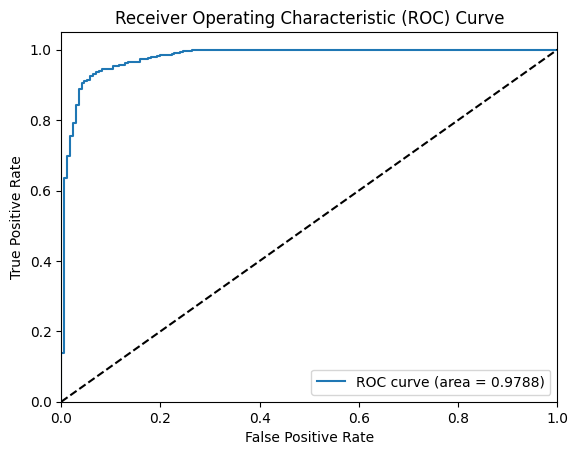

In [71]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--') # Ligne diagonale pour référence
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()